In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pickle
import random

path = os.getcwd().split(os.sep + 'GUI')[0]
if path not in sys.path:
    print("not here")
    sys.path.append(path)

from neurolib.models.aln import ALNModel
from neurolib.utils import plotFunctions as plotFunc
from neurolib.utils import costFunctions as cost
import neurolib.dashboard.functions as functions
import neurolib.dashboard.data as data
    
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2 

#path = os.path.join(os.getcwd(), "plots")

not here


In [2]:
grid_data_file = os.path.join(os.getcwd().split('data')[0], 'bi.pickle')
print(grid_data_file)
with open(grid_data_file,'rb') as f:
    load_array= pickle.load(f)
exc = load_array[0]
inh = load_array[1]
print(len(exc))

/home/lena/Promotion/neurolib/GUI/current/gui/bi.pickle
147


In [16]:
aln = ALNModel()
dt = 0.01
aln.params.dt = dt

data.set_parameters(aln)

state_vars = aln.state_vars
init_vars = aln.init_vars

##############################################################
def setinit(init_vars_, model):
    state_vars = model.state_vars
    init_vars = model.init_vars
    for iv in range(len(init_vars)):
        for sv in range(len(state_vars)):
            if state_vars[sv] in init_vars[iv]:
                #print("set init vars ", )
                if model.params[init_vars[iv]].ndim == 2:
                    model.params[init_vars[iv]][0,:] = init_vars_[sv]
                else:
                    model.params[init_vars[iv]][0] = init_vars_[sv]
                    
##############################################################               
def setmaxmincontrol(max_c_c, min_c_c, max_c_r, min_c_r):
    import numpy as np
    
    max_cntrl = np.zeros(( 6 ))
    min_cntrl = np.zeros(( 6 ))
    
    max_cntrl[0] = max_c_c
    min_cntrl[0] = min_c_c
    max_cntrl[1] = max_c_c
    min_cntrl[1] = min_c_c
    max_cntrl[2] = max_c_r
    min_cntrl[2] = min_c_r
    max_cntrl[3] = max_c_r
    min_cntrl[3] = min_c_r
    max_cntrl[4] = max_c_r
    min_cntrl[4] = min_c_r
    max_cntrl[5] = max_c_r
    min_cntrl[5] = min_c_r
            
    return max_cntrl, min_cntrl

In [17]:
dur = 500.
t_pen = 0.96

In [18]:
file_ = '1_I_dt.pickle'
c_var = [1]

folder = str(os.getcwd().split('data_2')[1])
print(folder)
case = str(folder[1])

/1


In [19]:
dur_pre = 10
dur_post = 10

n_pre = int(np.around(dur_pre/aln.params.dt + 1.,1))
n_post = int(np.around(dur_post/aln.params.dt + 1.,1))

tol = 1e-10
start_step = 10.
c_scheme = np.zeros(( 1,1 ))
c_scheme[0,0] = 1.
u_mat = np.identity(1)
u_scheme = np.array([[1.]])

p_var = [0]
wp = 1. / (dur - t_pen * dur)

if case in ['1', '2']:    # low to high
    max_I = [3., -3.]
else:
    max_I = [-3., 3.]
    
if case in ['1', '3']:    # sparsity
    factor_ws = 1.
    factor_we = 0.
else:
    factor_ws = 0.
    factor_we = 1.
    
maxC = [5., -5., 0.18, 0.]
max_cntrl, min_cntrl = setmaxmincontrol(maxC[0], maxC[1], maxC[2], maxC[3])

In [20]:
bestControl_ = None
bestState_ = None
cost_ = None
costnode_ = None
weights_ = None

if os.path.isfile(file_) :
    print("file found")
    
    with open(file_,'rb') as f:
        load_array = pickle.load(f)

    bestControl_ = load_array[0]
    bestState_ = load_array[1]
    cost_ = load_array[2]
    costnode_ = load_array[3]
    weights_ = load_array[4]

In [21]:
initVars = None
target = None
cost_uncontrolled = None

In [22]:
# get initial parameters and target states

i_range = [20]

data.set_parameters(aln)

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = 3000.
    
    control0 = aln.getZeroControl()
    control0 = functions.step_control(aln, maxI_ = max_I[0])

    aln.run(control=control0)
    
    target_rates = np.zeros((2))
    target_rates[0] = aln.rates_exc[0,-1] 
    target_rates[1] = aln.rates_inh[0,-1]

    control0 = functions.step_control(aln, maxI_ = max_I[1])
    aln.run(control=control0)

    init_state_vars = np.zeros(( len(state_vars) ))
    for j in range(len(state_vars)):
        if aln.state[state_vars[j]].size == 1:
            init_state_vars[j] = aln.state[state_vars[j]][0]
        else:
            init_state_vars[j] = aln.state[state_vars[j]][0,-1]

    initVars = init_state_vars
    target = [target_rates[0], target_rates[1]]

-------  20 0.4500000000000001 0.4750000000000002


In [23]:
# get uncontrolled cost
data.set_parameters(aln)

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = dur
    
    target_ = aln.getZeroTarget()
    target_[:,0,:] = target[0]
    target_[:,1,:] = target[1]
            
    cost.setParams(wp, 0.0, 0.0)

    setinit(initVars, aln)
    control0 = aln.getZeroControl()

    cgv = None
    max_it = 0

    bestControl_init_, bestState_init_, cost_init_, runtime_init_, grad_init_, phi_init_, phi1_, costnode_init_ = aln.A1(
        control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
        prec_variables_ = p_var, transition_time_ = t_pen)
    
    cost_uncontrolled = cost_init_[0]

-------  20 0.4500000000000001 0.4750000000000002
set cost params:  0.05 0.0 0.0
interpolate adjoint :  True True True
initial cost =  636.9058225136315
RUN  0 , total integrated cost =  636.9058225136315
Gradient descend method:  None
RUN  0 , total integrated cost =  636.9058225136315
Improved over  0  iterations in  0.0  seconds by  0.0  percent.


In [ ]:
cgv = None
j = 0
i = 20

print("------- ", i, exc[i], inh[i])
aln.params.ext_exc_current = exc[i] * 5.
aln.params.ext_inh_current = inh[i] * 5.

aln.params.duration = dur
setinit(initVars, aln)

target_ = aln.getZeroTarget()
target_[:,0,:] = target[0]
target_[:,1,:] = target[1]

control0 = aln.getZeroControl()
cost.setParams(wp, 0., 10.)
max_it = int(10)

control0[0,1,22000:28000] = -2.

bestControl_, bestState_, cost_, runtime_, grad_, phi_, phi1_, costnode_ = aln.A1(
    control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
    startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
    t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
    prec_variables_ = p_var, transition_time_ = t_pen)

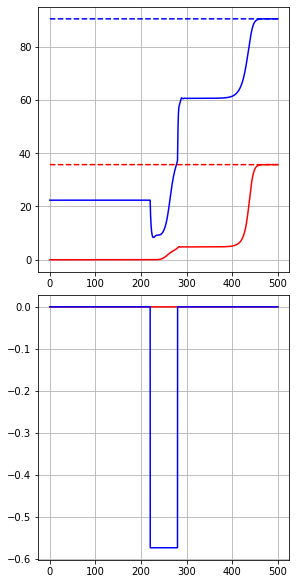

uncontrolled cost :  636.9058225136315
cost splitting :  2.089516241846437e-06 [0.         4.43914985]


In [28]:
plot_time_array = np.arange(0.,round(dur+aln.params.dt,2),aln.params.dt)
target_ = aln.getZeroTarget()
target_[:,0,:] = target[0]
target_[:,1,:] = target[1]

fig, ax = plt.subplots(2,1, constrained_layout=True, figsize = (4,8) )
ax[1].plot(plot_time_array, bestControl_[0,0,n_pre-1:-n_post+1], color = 'red')
ax[0].plot(plot_time_array, bestState_[0,0,n_pre-1:-n_post+1], color= 'red')
ax[1].plot(plot_time_array, bestControl_[0,1,n_pre-1:-n_post+1], color = 'blue')
ax[0].plot(plot_time_array, bestState_[0,1,n_pre-1:-n_post+1], color= 'blue')
ax[0].plot(plot_time_array, target_[0,0,n_pre-1:-n_post+1], linestyle = '--', color='red')
ax[0].plot(plot_time_array, target_[0,1,n_pre-1:-n_post+1], linestyle = '--', color='blue')
plt.show()

print('uncontrolled cost : ', cost_uncontrolled)
print('cost splitting : ', costnode_[0][0][0], costnode_[2][0][:2])    

set cost params:  0.05 0.0 48.280618362325875
interpolate adjoint :  True True True
initial cost =  161.32139810323395
RUN  0 , total integrated cost =  161.32139810323395
Gradient descend method:  None
RUN  1 , total integrated cost =  161.32139745735583
RUN  2 , total integrated cost =  161.32139745692686
RUN  3 , total integrated cost =  161.32139745692598
RUN  4 , total integrated cost =  161.32139745692598
Control only changes marginally.
RUN  4 , total integrated cost =  161.32139745692598
Improved over  4  iterations in  21.791509750997648  seconds by  4.006337519513181e-07  percent.
cost splitting :  1.2531515106819111e-05 [5.35833972e-13 3.34132831e+00]


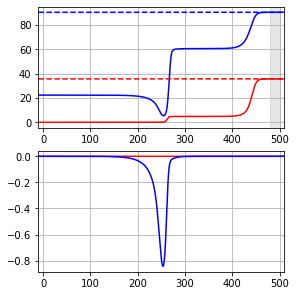

set cost params:  0.05 0.0 75.7610513994343
interpolate adjoint :  True True True
initial cost =  253.1425462620232
RUN  0 , total integrated cost =  253.1425462620232
Gradient descend method:  None
RUN  1 , total integrated cost =  253.14254619105236
RUN  2 , total integrated cost =  253.1425461910476
RUN  3 , total integrated cost =  253.1425461910476
Control only changes marginally.
RUN  3 , total integrated cost =  253.1425461910476
Improved over  3  iterations in  14.854276325990213  seconds by  2.8037803190272825e-08  percent.
cost splitting :  1.8316805963677073e-05 [5.35833972e-13 3.34132830e+00]


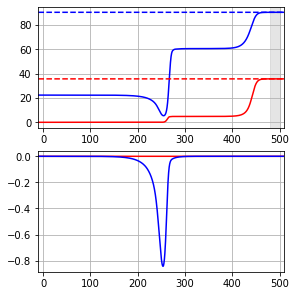

set cost params:  0.05 0.0 57.41620812275303
interpolate adjoint :  True True True
initial cost =  191.8464021440215
RUN  0 , total integrated cost =  191.8464021440215
Gradient descend method:  None
RUN  1 , total integrated cost =  191.84640211895308
RUN  2 , total integrated cost =  191.84640211893557
RUN  3 , total integrated cost =  191.84640211893557
Control only changes marginally.
RUN  3 , total integrated cost =  191.84640211893557
Improved over  3  iterations in  14.98117873899173  seconds by  1.3076046911919548e-08  percent.
cost splitting :  1.4494270323256037e-05 [5.35833972e-13 3.34132831e+00]


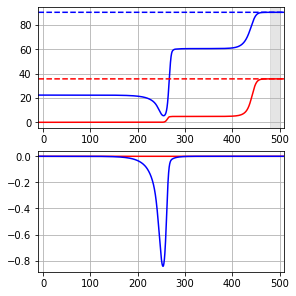

set cost params:  0.05 0.0 96.48466926821695
interpolate adjoint :  True True True
initial cost =  322.38695719604885
RUN  0 , total integrated cost =  322.38695719604885
Gradient descend method:  None
RUN  1 , total integrated cost =  322.3869570822621
RUN  2 , total integrated cost =  322.386957082079
RUN  3 , total integrated cost =  322.386957082079
Control only changes marginally.
RUN  3 , total integrated cost =  322.386957082079
Improved over  3  iterations in  21.619366164988605  seconds by  3.535188852765714e-08  percent.
cost splitting :  2.244850280168794e-05 [5.35833972e-13 3.34132830e+00]


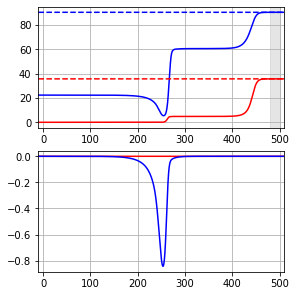

set cost params:  0.05 0.0 131.26815227552757
interpolate adjoint :  True True True
initial cost =  438.6099932333273
RUN  0 , total integrated cost =  438.6099932333273
Gradient descend method:  None
RUN  1 , total integrated cost =  438.609993179434
RUN  2 , total integrated cost =  438.6099931793806
RUN  3 , total integrated cost =  438.6099931793806
Control only changes marginally.
RUN  3 , total integrated cost =  438.6099931793806
Improved over  3  iterations in  21.374016093992395  seconds by  1.2299466334297904e-08  percent.
cost splitting :  2.9064069283550863e-05 [5.35833972e-13 3.34132830e+00]


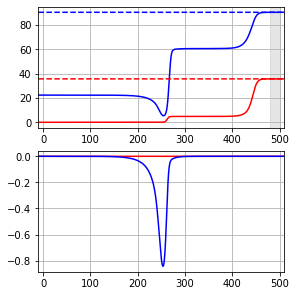

set cost params:  0.05 0.0 160.60865371521095
interpolate adjoint :  True True True
initial cost =  536.6462408953515
RUN  0 , total integrated cost =  536.6462408953515
Gradient descend method:  None
RUN  1 , total integrated cost =  536.6462408672268
RUN  2 , total integrated cost =  536.6462408671949
RUN  3 , total integrated cost =  536.6462408671932
RUN  4 , total integrated cost =  536.6462408671932
Control only changes marginally.
RUN  4 , total integrated cost =  536.6462408671932
Improved over  4  iterations in  28.451216985005885  seconds by  5.247088097348751e-09  percent.
cost splitting :  3.4393667921286e-05 [5.35833972e-13 3.34132830e+00]


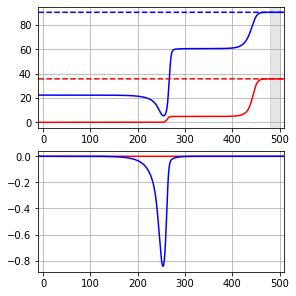

set cost params:  0.05 0.0 58.17053003515652
interpolate adjoint :  True True True
initial cost =  194.36683968557256
RUN  0 , total integrated cost =  194.36683968557256
Gradient descend method:  None
RUN  1 , total integrated cost =  194.36683927637625
RUN  2 , total integrated cost =  194.36683927623676
RUN  3 , total integrated cost =  194.36683927623676
Control only changes marginally.
RUN  3 , total integrated cost =  194.36683927623676
Improved over  3  iterations in  19.401686514000176  seconds by  2.1059960886304907e-07  percent.
cost splitting :  1.4645475216619493e-05 [5.35833972e-13 3.34132831e+00]


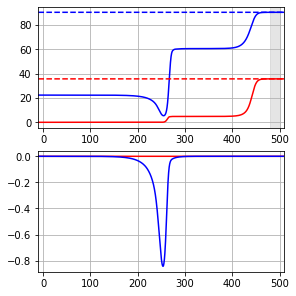

set cost params:  0.05 0.0 112.60543060294805
interpolate adjoint :  True True True
initial cost =  376.25171334257544
RUN  0 , total integrated cost =  376.25171334257544
Gradient descend method:  None
RUN  1 , total integrated cost =  376.2517131386106
RUN  2 , total integrated cost =  376.2517131379861
RUN  3 , total integrated cost =  376.25171313798467
RUN  4 , total integrated cost =  376.25171313798467
Control only changes marginally.
RUN  4 , total integrated cost =  376.25171313798467
Improved over  4  iterations in  28.076954114018008  seconds by  5.4376030789171637e-08  percent.
cost splitting :  2.5536506183411153e-05 [5.35833972e-13 3.34132830e+00]


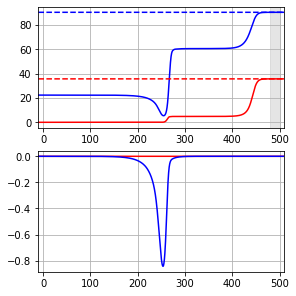

set cost params:  0.05 0.0 161.9533002492839
interpolate adjoint :  True True True
initial cost =  541.1391464679463
RUN  0 , total integrated cost =  541.1391464679463
Gradient descend method:  None
RUN  1 , total integrated cost =  541.1391463789537
RUN  2 , total integrated cost =  541.1391463787494
RUN  3 , total integrated cost =  541.1391463787494
Control only changes marginally.
RUN  3 , total integrated cost =  541.1391463787494
Improved over  3  iterations in  23.640763275005156  seconds by  1.6483170384162804e-08  percent.
cost splitting :  3.468853718517844e-05 [5.35833972e-13 3.34132830e+00]


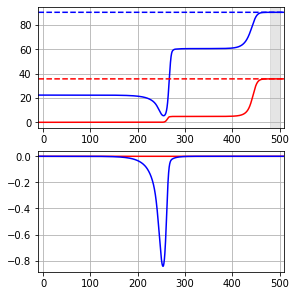

set cost params:  0.05 0.0 55.97613220489
interpolate adjoint :  True True True
initial cost =  187.03463613352196
RUN  0 , total integrated cost =  187.03463613352196
Gradient descend method:  None
RUN  1 , total integrated cost =  187.03463569268786
RUN  2 , total integrated cost =  187.03463569233944
RUN  3 , total integrated cost =  187.0346356923385
RUN  4 , total integrated cost =  187.0346356923385
Control only changes marginally.
RUN  4 , total integrated cost =  187.0346356923385
Improved over  4  iterations in  23.83796685701236  seconds by  2.3588329156609689e-07  percent.
cost splitting :  1.4188323364826823e-05 [5.35833972e-13 3.34132831e+00]


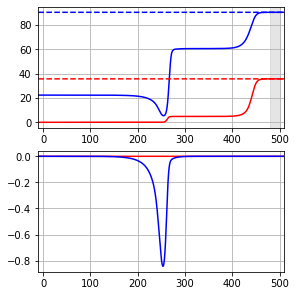

set cost params:  0.05 0.0 186.0974168395219
interpolate adjoint :  True True True
initial cost =  621.8125672233288
RUN  0 , total integrated cost =  621.8125672233288
Gradient descend method:  None
RUN  1 , total integrated cost =  621.8125662931302
RUN  2 , total integrated cost =  621.8125662921443
RUN  3 , total integrated cost =  621.8125662921443
Control only changes marginally.
RUN  3 , total integrated cost =  621.8125662921443
Improved over  3  iterations in  22.711633669998264  seconds by  1.497532338134988e-07  percent.
cost splitting :  3.896270640101595e-05 [5.35833972e-13 3.34132829e+00]


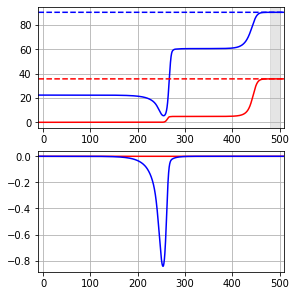

set cost params:  0.05 0.0 68.26737886059847
interpolate adjoint :  True True True
initial cost =  228.10372649880108
RUN  0 , total integrated cost =  228.10372649880108
Gradient descend method:  None
RUN  1 , total integrated cost =  228.1037260427456
RUN  2 , total integrated cost =  228.10372604270435
RUN  3 , total integrated cost =  228.10372604270435
Control only changes marginally.
RUN  3 , total integrated cost =  228.10372604270435
Improved over  3  iterations in  17.4037759740022  seconds by  1.9995145805751235e-07  percent.
cost splitting :  1.677058759220733e-05 [5.35833972e-13 3.34132830e+00]


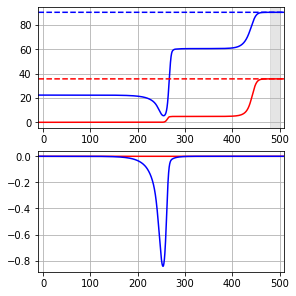

set cost params:  0.05 0.0 18.448457449730952
interpolate adjoint :  True True True
initial cost =  61.6423538743385
RUN  0 , total integrated cost =  61.6423538743385
Gradient descend method:  None
RUN  1 , total integrated cost =  61.64235359198898
RUN  2 , total integrated cost =  61.642353591792435
RUN  3 , total integrated cost =  61.642353591792435
Control only changes marginally.
RUN  3 , total integrated cost =  61.642353591792435
Improved over  3  iterations in  17.344967827986693  seconds by  4.58363516031568e-07  percent.
cost splitting :  5.568111033778306e-06 [5.35833972e-13 3.34132832e+00]


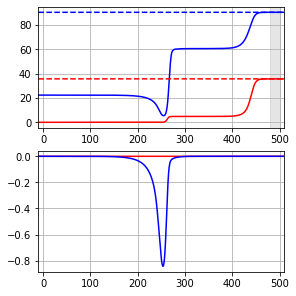

set cost params:  0.05 0.0 152.39941873808593
interpolate adjoint :  True True True
initial cost =  509.21649386361264
RUN  0 , total integrated cost =  509.21649386361264
Gradient descend method:  None
RUN  1 , total integrated cost =  509.21649175513414
RUN  2 , total integrated cost =  509.21649175254856
RUN  3 , total integrated cost =  509.2164917525384
RUN  4 , total integrated cost =  509.2164917525356
RUN  5 , total integrated cost =  509.2164917525356
Control only changes marginally.
RUN  5 , total integrated cost =  509.2164917525356
Improved over  5  iterations in  27.104439357004594  seconds by  4.145735772453918e-07  percent.
cost splitting :  3.2960007615494704e-05 [5.35833972e-13 3.34132830e+00]


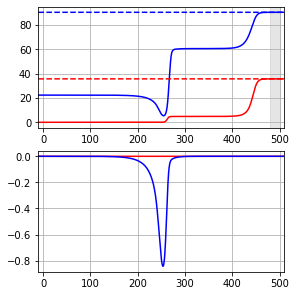

set cost params:  0.05 0.0 37.895727229691815
interpolate adjoint :  True True True
initial cost =  126.62206733334678
RUN  0 , total integrated cost =  126.62206733334678
Gradient descend method:  None
RUN  1 , total integrated cost =  126.62206673445327
RUN  2 , total integrated cost =  126.62206673336318
RUN  3 , total integrated cost =  126.62206673336
RUN  4 , total integrated cost =  126.62206673335952
RUN  5 , total integrated cost =  126.62206673335952
Control only changes marginally.
RUN  5 , total integrated cost =  126.62206673335952
Improved over  5  iterations in  29.66166117999819  seconds by  4.7384098422753596e-07  percent.
cost splitting :  1.0221561272476087e-05 [5.35833972e-13 3.34132831e+00]


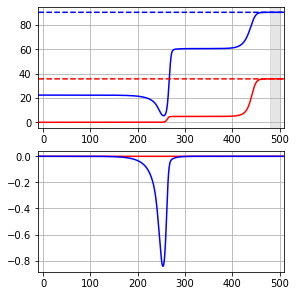

set cost params:  0.05 0.0 145.51300434894918
interpolate adjoint :  True True True
initial cost =  486.20672142180416
RUN  0 , total integrated cost =  486.20672142180416
Gradient descend method:  None
RUN  1 , total integrated cost =  486.20672049644685
RUN  2 , total integrated cost =  486.2067204955133
RUN  3 , total integrated cost =  486.2067204955133
Control only changes marginally.
RUN  3 , total integrated cost =  486.2067204955133
Improved over  3  iterations in  18.137595696025528  seconds by  1.9051378785661655e-07  percent.
cost splitting :  3.169543843378604e-05 [5.35833972e-13 3.34132830e+00]


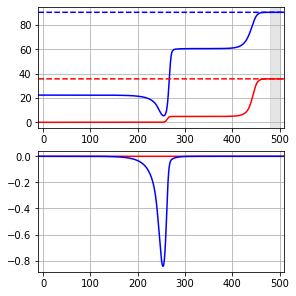

set cost params:  0.05 0.0 73.59230838481325
interpolate adjoint :  True True True
initial cost =  245.8960639809703
RUN  0 , total integrated cost =  245.8960639809703
Gradient descend method:  None
RUN  1 , total integrated cost =  245.8960637750891
RUN  2 , total integrated cost =  245.8960637748859
RUN  3 , total integrated cost =  245.8960637748859
Control only changes marginally.
RUN  3 , total integrated cost =  245.8960637748859
Improved over  3  iterations in  21.50066621802398  seconds by  8.380955307529803e-08  percent.
cost splitting :  1.7851042992887674e-05 [5.35833972e-13 3.34132830e+00]


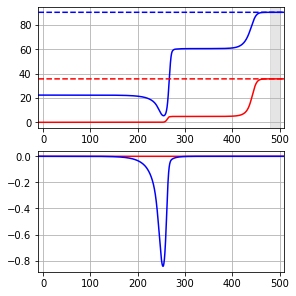

set cost params:  0.05 0.0 48.96429495626439
interpolate adjoint :  True True True
initial cost =  163.60578546173636
RUN  0 , total integrated cost =  163.60578546173636
Gradient descend method:  None
RUN  1 , total integrated cost =  163.6057854132521
RUN  2 , total integrated cost =  163.6057854131575
RUN  3 , total integrated cost =  163.60578541308757
RUN  4 , total integrated cost =  163.60578541308757
Control only changes marginally.
RUN  4 , total integrated cost =  163.60578541308757
Improved over  4  iterations in  22.27590245899046  seconds by  2.9735375051131996e-08  percent.
cost splitting :  1.2675669718943896e-05 [5.35833972e-13 3.34132831e+00]


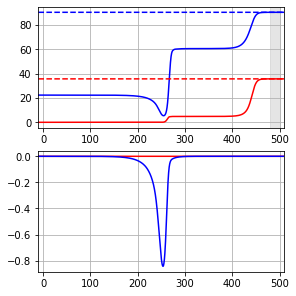

set cost params:  0.05 0.0 170.88814339284892
interpolate adjoint :  True True True
initial cost =  570.9933915166306
RUN  0 , total integrated cost =  570.9933915166306
Gradient descend method:  None
RUN  1 , total integrated cost =  570.9933905859322
RUN  2 , total integrated cost =  570.9933905858943
RUN  3 , total integrated cost =  570.9933905858943
Control only changes marginally.
RUN  3 , total integrated cost =  570.9933905858943
Improved over  3  iterations in  22.85381548301666  seconds by  1.6300299421345699e-07  percent.
cost splitting :  3.625648588049553e-05 [5.35833972e-13 3.34132829e+00]


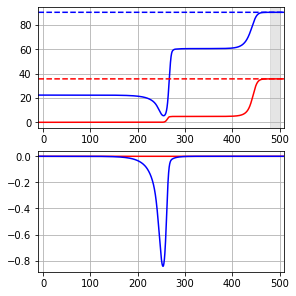

set cost params:  0.05 0.0 88.15080131897295
interpolate adjoint :  True True True
initial cost =  294.5407684736918
RUN  0 , total integrated cost =  294.5407684736918
Gradient descend method:  None
RUN  1 , total integrated cost =  294.5407682494304
RUN  2 , total integrated cost =  294.540768249278
RUN  3 , total integrated cost =  294.5407682492771
RUN  4 , total integrated cost =  294.5407682492771
Control only changes marginally.
RUN  4 , total integrated cost =  294.5407682492771
Improved over  4  iterations in  25.417831536993617  seconds by  7.619138386871782e-08  percent.
cost splitting :  2.0778657840287218e-05 [5.35833972e-13 3.34132830e+00]


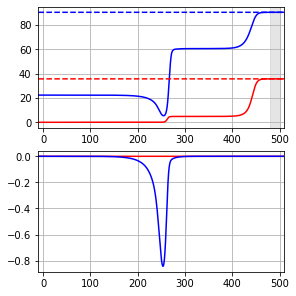

set cost params:  0.05 0.0 137.4957591036851
interpolate adjoint :  True True True
initial cost =  459.41847221114614
RUN  0 , total integrated cost =  459.41847221114614
Gradient descend method:  None
RUN  1 , total integrated cost =  459.4184720966055
RUN  2 , total integrated cost =  459.4184720965958
RUN  3 , total integrated cost =  459.4184720965958
Control only changes marginally.
RUN  3 , total integrated cost =  459.4184720965958
Improved over  3  iterations in  21.017786426993553  seconds by  2.4933768827395397e-08  percent.
cost splitting :  3.0217044262663104e-05 [5.35833972e-13 3.34132830e+00]


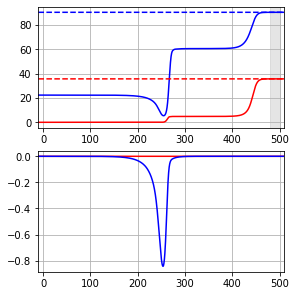

set cost params:  0.05 0.0 162.10373874927788
interpolate adjoint :  True True True
initial cost =  541.6418108139595
RUN  0 , total integrated cost =  541.6418108139595
Gradient descend method:  None
RUN  1 , total integrated cost =  541.6418107949557
RUN  2 , total integrated cost =  541.6418107948923
RUN  3 , total integrated cost =  541.6418107948923
Control only changes marginally.
RUN  3 , total integrated cost =  541.6418107948923
Improved over  3  iterations in  23.64986567001324  seconds by  3.5202560866309796e-09  percent.
cost splitting :  3.471209452598766e-05 [5.35833972e-13 3.34132830e+00]


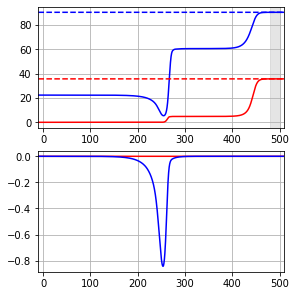

set cost params:  0.05 0.0 11.82640071295288
interpolate adjoint :  True True True
initial cost =  39.515889069525834
RUN  0 , total integrated cost =  39.515889069525834
Gradient descend method:  None
RUN  1 , total integrated cost =  39.51588787148039
RUN  2 , total integrated cost =  39.515887871217664
RUN  3 , total integrated cost =  39.515887871217274
RUN  4 , total integrated cost =  39.515887871217274
Control only changes marginally.
RUN  4 , total integrated cost =  39.515887871217274
Improved over  4  iterations in  22.8579019390163  seconds by  3.032472733366376e-06  percent.
cost splitting :  3.8215267064057236e-06 [5.35833972e-13 3.34132832e+00]


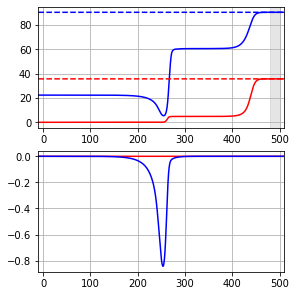

set cost params:  0.05 0.0 151.68835167702446
interpolate adjoint :  True True True
initial cost =  506.8405861598885
RUN  0 , total integrated cost =  506.8405861598885
Gradient descend method:  None
RUN  1 , total integrated cost =  506.84058326086426
RUN  2 , total integrated cost =  506.8405832605878
RUN  3 , total integrated cost =  506.84058326058636
RUN  4 , total integrated cost =  506.8405832605838
RUN  5 , total integrated cost =  506.8405832605754
RUN  6 , total integrated cost =  506.8405832605754
Control only changes marginally.
RUN  6 , total integrated cost =  506.8405832605754
Improved over  6  iterations in  30.923471533023985  seconds by  5.720364981698367e-07  percent.
cost splitting :  3.2835915395782605e-05 [5.35833972e-13 3.34132830e+00]


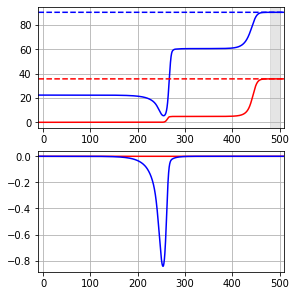

set cost params:  0.05 0.0 58.253783279800025
interpolate adjoint :  True True True
initial cost =  194.64501605855045
RUN  0 , total integrated cost =  194.64501605855045
Gradient descend method:  None
RUN  1 , total integrated cost =  194.64501569891058
RUN  2 , total integrated cost =  194.6450156988497
RUN  3 , total integrated cost =  194.6450156988497
Control only changes marginally.
RUN  3 , total integrated cost =  194.6450156988497
Improved over  3  iterations in  17.25867075001588  seconds by  1.8479833840956417e-07  percent.
cost splitting :  1.468286942564983e-05 [5.35833972e-13 3.34132831e+00]


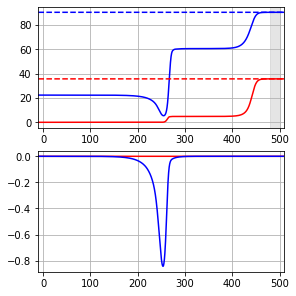

set cost params:  0.05 0.0 154.2968414172782
interpolate adjoint :  True True True
initial cost =  515.5564043829901
RUN  0 , total integrated cost =  515.5564043829901
Gradient descend method:  None
RUN  1 , total integrated cost =  515.5564038394855
RUN  2 , total integrated cost =  515.5564038390893
RUN  3 , total integrated cost =  515.5564038390893
Control only changes marginally.
RUN  3 , total integrated cost =  515.5564038390893
Improved over  3  iterations in  22.15935557099874  seconds by  1.0549781848112616e-07  percent.
cost splitting :  3.327777132986717e-05 [5.35833972e-13 3.34132830e+00]


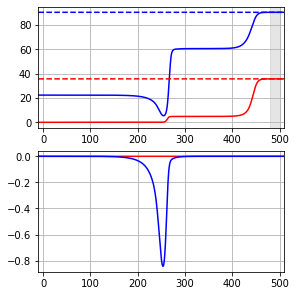

set cost params:  0.05 0.0 164.56881148553424
interpolate adjoint :  True True True
initial cost =  549.8784280814366
RUN  0 , total integrated cost =  549.8784280814366
Gradient descend method:  None
RUN  1 , total integrated cost =  549.878428078366
RUN  2 , total integrated cost =  549.878428078366
Control only changes marginally.
RUN  2 , total integrated cost =  549.878428078366
Improved over  2  iterations in  10.422144098993158  seconds by  5.584155360338627e-10  percent.
cost splitting :  3.514064763377396e-05 [5.35833972e-13 3.34132830e+00]


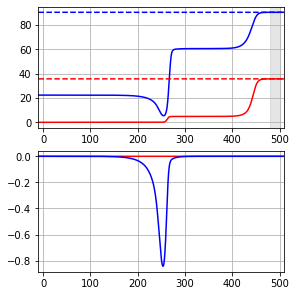

In [44]:
c_var = [0,1]
conv = None
max_it = int(30)

tol = 1. * 1e-12
        
while not conv:

    weight_ = random.random() * ( cost_uncontrolled -
                                 costnode_[0][0][0] ) / sum( costnode_[2][0][:] )

    aln.params.duration = dur
    cost.setParams(wp, weight_ * factor_we, weight_ * factor_ws)
    weights_ = cost.getParams()

    setinit(initVars, aln)

    target_ = aln.getZeroTarget()
    target_[:,0,:] = target[0]
    target_[:,1,:] = target[1]

    control0 = aln.getZeroControl()
    control0 = bestControl_[:,:,n_pre-1:-n_post+1]

    bestControl_, bestState_, cost_, runtime_, grad_, phi_, phi1_, costnode_ = aln.A1(
        control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
        prec_variables_ = p_var, transition_time_ = t_pen)

    if cost_[3] == 0.:
        conv = True

    #print('uncontrolled cost : ', cost_uncontrolled[i])
    print('cost splitting : ', costnode_[0][0][0], costnode_[2][0][:2])

    time_ = np.arange(-dur_pre,round(dur+dur_post+aln.params.dt,2),aln.params.dt)
    target_ = aln.getZeroTarget()
    target_[:,0,:] = target[0]
    target_[:,1,:] = target[1]

    fig, ax = plt.subplots(2,1, constrained_layout=True, figsize = (4,4) )
    ax[1].plot(time_, bestControl_[0,0,:], color = 'red')
    ax[0].plot(time_, bestState_[0,0,:], color= 'red')
    ax[1].plot(time_, bestControl_[0,1,:], color = 'blue')
    ax[0].plot(time_, bestState_[0,1,:], color= 'blue')
    ax[0].plot(time_, target_[0,0,:], linestyle = '--', color='red')
    ax[0].plot(time_, target_[0,1,:], linestyle = '--', color='blue')
    ax[0].set_xlim(-dur_pre,dur+dur_post)
    ax[1].set_xlim(-dur_pre,dur+dur_post)
    ax[0].axvspan(dur*t_pen, dur, alpha=0.2, color='gray')
    plt.show()

    with open(file_,'wb') as f:
        pickle.dump([bestControl_, bestState_, cost_, costnode_, weights_], f)